In [8]:
import cdsapi
import xarray as xr
import numpy as np
import scipy.stats as stats
import dask.array as da
import dask
from dask.diagnostics import ProgressBar
from scipy import stats
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

### Optional: Download data

In [1]:
dataset = "reanalysis-era5-single-levels-monthly-means"
request = {
    "product_type": ["monthly_averaged_reanalysis"],
    "variable": [
        "total_precipitation",
        "evaporation",
        "precipitation_type",
        "snow_depth",
        "snowfall"
    ],
    "year": [
        "1980", "1981", "1982",
        "1983", "1984", "1985",
        "1986", "1987", "1988",
        "1989", "1990", "1991",
        "1992", "1993", "1994",
        "1995", "1996", "1997",
        "1998", "1999", "2000",
        "2001", "2002", "2003",
        "2004", "2005", "2006",
        "2007", "2008", "2009",
        "2010", "2011", "2012",
        "2013", "2014", "2015",
        "2016", "2017", "2018",
        "2019", "2020", "2021",
        "2022"
    ],
    "month": ["03", "04", "05"],
    "time": ["00:00"],
    "data_format": "netcdf",
    "download_format": "unarchived",
    "area": [90, -180, 0, 180]
}

client = cdsapi.Client()
client.retrieve(dataset, request).download()


2025-09-04 10:51:36,290 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-09-04 10:51:37,088 INFO Request ID is 8b494f42-05f5-417a-83c4-8be02b5f2f4b
2025-09-04 10:51:37,312 INFO status has been updated to accepted
2025-09-04 10:51:46,722 INFO status has been updated to running
2025-09-04 10:53:33,520 INFO status has been updated to successful


3856d60c0f38dbc15fc3cbdb49711b99.zip:   0%|          | 0.00/356M [00:00<?, ?B/s]

'3856d60c0f38dbc15fc3cbdb49711b99.zip'

### Load data

In [2]:
# === Load data ===
p = xr.open_dataset('/pscratch/sd/s/skygale/data/totalprecip_evap_snowfall.nc').tp
e = xr.open_dataset('/pscratch/sd/s/skygale/data/totalprecip_evap_snowfall.nc').e
sf = xr.open_dataset('/pscratch/sd/s/skygale/data/totalprecip_evap_snowfall.nc').sf
sd = xr.open_dataset('/pscratch/sd/s/skygale/data/snow_depth.nc').sd
ptype = xr.open_dataset('/pscratch/sd/s/skygale/data/precip_type.nc').ptype

# === Setup ===
lat = p.latitude.values
lon = p.longitude.values

years = np.arange(1980, 2023)
month_names = ["March", "April", "May"]
months = np.arange(3, 6)

# === Check ===
p.shape, e.shape

((129, 361, 1440), (129, 361, 1440))

### Calculate trends

In [4]:
def calculate_monthly_trends_optimized(data):
    """Calculate linear trends (per decade) for March, April, May using Dask and apply_ufunc."""

    # Time array for regression (assumes 43 years)
    time = np.arange(43)

    # Prepare output list for each month
    monthly_trends = []

    for month in [3, 4, 5]:
        # Select data for the given month
        monthly_data = data.sel(valid_time=data.valid_time.dt.month == month)

        # Stack spatial dimensions for vectorized processing
        stacked = monthly_data.stack(points=("latitude", "longitude")).chunk({'valid_time': -1})

        # Define function to compute slope
        def compute_slope(y):
            slope, _ = np.polyfit(time, y, 1)
            return slope * 10  # convert to per decade

        # Apply slope function across time dimension
        trends = xr.apply_ufunc(
            compute_slope,
            stacked,
            input_core_dims=[["valid_time"]],
            output_core_dims=[[]],
            vectorize=True,
            dask="parallelized",
            output_dtypes=[float],
        )

        # Unstack back to (lat, lon)
        trends = trends.unstack("points")

        # Add to list
        monthly_trends.append(trends)

    # Combine into a single DataArray with a 'month' dimension
    trend_ds = xr.concat(monthly_trends, dim="month")
    trend_ds["month"] = ["March", "April", "May"]
    trend_ds.name = "Monthly Trend"

    return trend_ds


# Make sure data is chunked appropriately
p = p.chunk({"valid_time": 10, "latitude": 20, "longitude": 20})
e = e.chunk({"valid_time": 10, "latitude": 20, "longitude": 20})

# Calculate trends
p_trends = calculate_monthly_trends_optimized(p)
e_trends = calculate_monthly_trends_optimized(e)

# Trigger computation
from dask.diagnostics import ProgressBar
with ProgressBar():
    p_trends_computed = p_trends.compute()
    e_trends_computed = e_trends.compute()

# Inspect result
print(p_trends_computed.shape)  # (3, lat, lon)


[########################################] | 100% Completed | 421.95 s
[########################################] | 100% Completed | 469.11 s
(3, 361, 1440)


### Plot trends

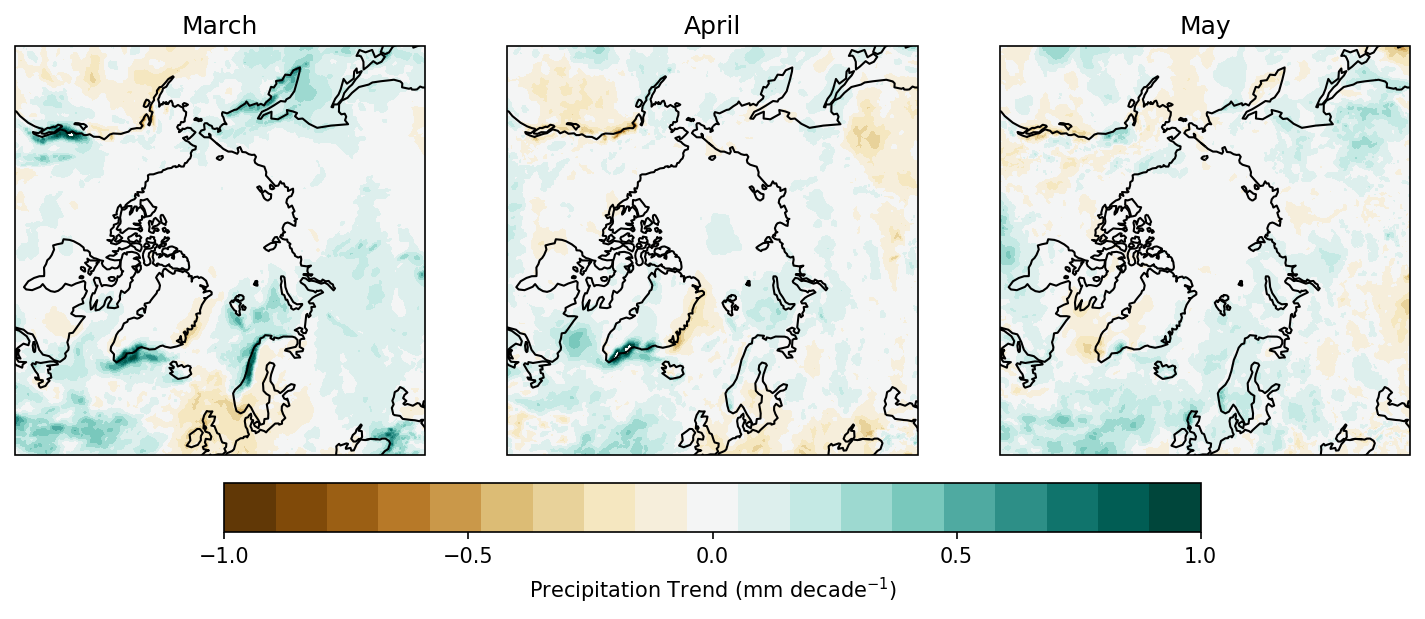

In [22]:
# === Precipitation ===
fig, axes = plt.subplots(1, 3, figsize=(12, 12), dpi=150, subplot_kw={'projection': ccrs.NorthPolarStereo()})
axes = axes.ravel()

for i, ax in enumerate(axes):
    ax.set_extent([-180, 180, 50, 90], crs=ccrs.PlateCarree())

    im = ax.contourf(
        lon, lat,
        p_trends_computed[i]*1000,
        cmap="BrBG",
        levels=np.linspace(-1, 1, 20),
        transform=ccrs.PlateCarree()
    )

    ax.grid(alpha=0.3)
    ax.coastlines()
    ax.set_title(month_names[i])

cbar = fig.colorbar(im, ax=axes, orientation='horizontal', ticks=np.linspace(-1, 1, 5), shrink=0.7, pad=0.02)
cbar.set_label('Precipitation Trend (mm decade$^{-1}$)')
plt.savefig('../figures/Precipitation_Trend_MAM.png', dpi=300)

plt.show()

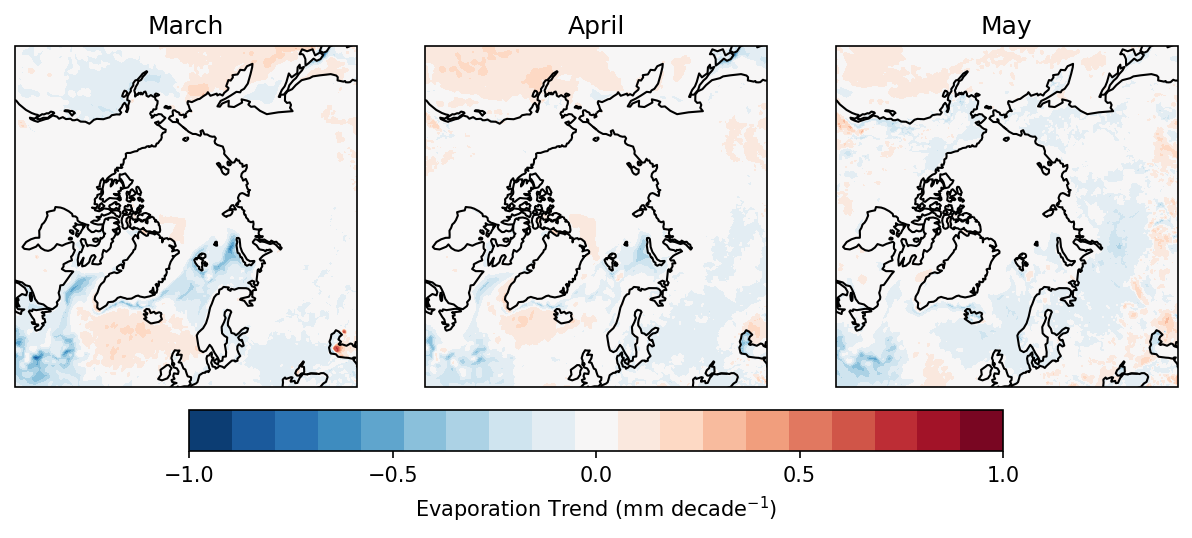

In [23]:
# === Evaporation ===
fig, axes = plt.subplots(1, 3, figsize=(10, 10), dpi=150, subplot_kw={'projection': ccrs.NorthPolarStereo()})
axes = axes.ravel()

for i, ax in enumerate(axes):
    ax.set_extent([-180, 180, 50, 90], crs=ccrs.PlateCarree())

    im = ax.contourf(
        lon, lat,
        e_trends_computed[i]*1000,
        cmap="RdBu_r",
        levels=np.linspace(-1, 1, 20),
        transform=ccrs.PlateCarree()
    )

    ax.grid(alpha=0.3)
    ax.coastlines()
    ax.set_title(month_names[i])

cbar = fig.colorbar(im, ax=axes, orientation='horizontal', ticks=np.linspace(-1, 1, 5), shrink=0.7, pad=0.02)
cbar.set_label('Evaporation Trend (mm decade$^{-1}$)')
plt.savefig('../figures/Evaporation_Trend_MAM.png', dpi=300)

plt.show()